In [1]:
import pandas as pd
import numpy as np
import geopandas as geopd

import shapely
from shapely import Polygon

import rasterio
from rasterio import features

from graph_utils import get_start_and_end_nodes, check_network_topology, get_pour

import os

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt


pd.set_option('display.max_rows', 20)

plt.rcParams["figure.dpi"]  = 400
plt.style.use('dark_background')

## The networks need to be checked for 
- loops
- multiple pour points
- sources at the edge (problems with watershed boundaries)

In [5]:
vector_watershed_path = "/home/iiro/Documents/DIWA/data/hydrology_iiro/watersheds.gpkg"
watersheds = geopd.read_file(vector_watershed_path, layer='watersheds')

src_path = "/home/iiro/Documents/DIWA/data/hydrology_iiro/network.gpkg"

In [6]:
pbar = tqdm(watersheds.iterrows(), total=len(watersheds))

for i, watershed in pbar:
    # Changing to GeoDataFrame
    watershed = geopd.GeoDataFrame(
                    dict(zip(list(watershed.index), list(watershed.values))),
                    crs=watersheds.crs, geometry='geometry', index=[0])

    # Getting the gauge that corresponds to the watershed
    place_id = watershed.at[0, 'Paikka_Id']

    # Reading the previously created layers
    pour = geopd.read_file(src_path, layer=f"pour_{place_id}") 
    nodes = geopd.read_file(src_path, layer=f"nodes_{place_id}")
    network = geopd.read_file(src_path, layer=f"network_{place_id}")
    
    boundary = watershed.boundary.explode().reset_index()
    boundary['length'] = boundary.length
    boundary = boundary.loc[boundary['length'] > 160]
    boundary = boundary.rename({0:'geometry'}, axis=1)
    boundary = boundary.set_geometry('geometry', crs=watersheds.crs)

    nodes = nodes.assign(boundary_distance=lambda row: row.distance(boundary.at[0, 'geometry']))

    # Checking that there is only one point (pour) intersecting with the boundary
    boundary_nodes = nodes.loc[nodes['boundary_distance'] < 0.1]
    if len(boundary_nodes) > 1:
        print(f"Watershed clips the network in multiple places for {place_id}")

    
    

  0%|          | 0/142 [00:00<?, ?it/s]

(265159.5, 299270.5, 6901248.0, 6958052.0)

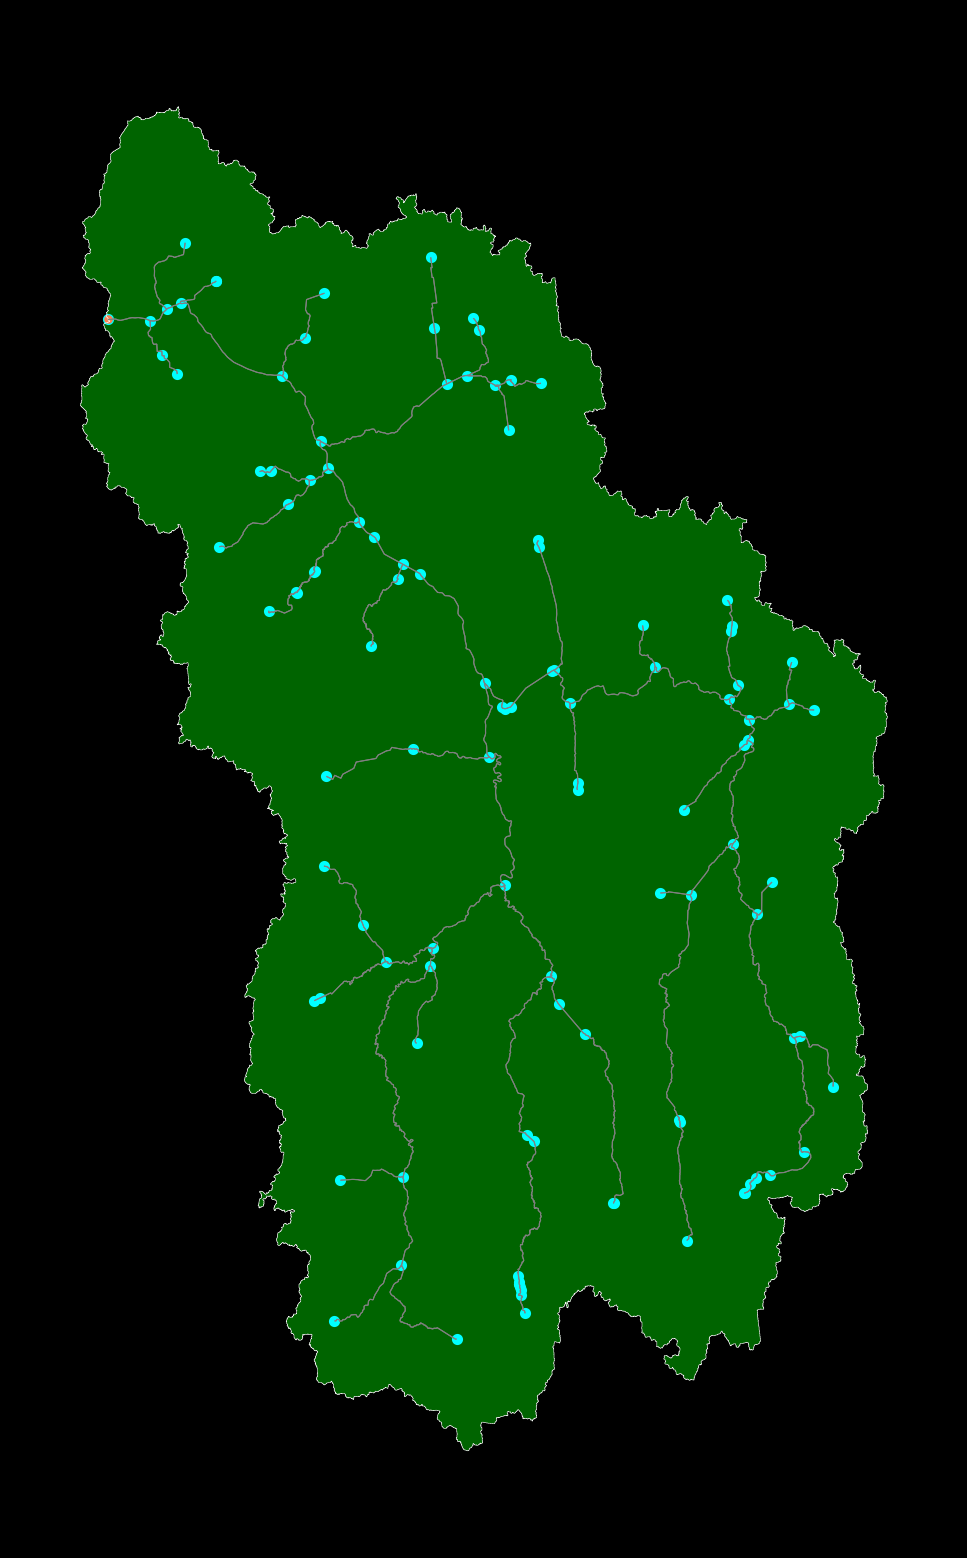

In [4]:
ax = watershed.plot(color='darkgreen')
ax = boundary.plot(ax=ax, color='white', linewidth=0.1)
ax = network.plot(ax=ax, color='grey', linewidth=0.2)
ax = nodes.plot(ax=ax, markersize=1, color='aqua')
ax = boundary_nodes.plot(color='coral', ax=ax, markersize=0.3)

plt.axis('off')

# Testing for loops

In [28]:
def is_loopy(nodes, pour_id):
    """ Traverses trough connections of a graph and 
    checks if any of the encountered nodes has been met previously
    """

    current_node = pour_id
    visited = [pour_id]

    # Getting the next node (and removing already visited locations)
    next_nodes = nodes.loc[nodes['next'] == current_node]
    next_nodes = next_nodes[~next_nodes['id'].isin(visited)]
    search_buffer = list(next_nodes["id"])
    # TODO the inverse of previous line could be saved to check for loops

    duplicates = []
    
    while len(search_buffer) > 0:
        current_node = search_buffer.pop(-1)
        visited.append(current_node)
        
        next_nodes = nodes.loc[nodes['next'] == current_node]
        next_nodes = next_nodes[~next_nodes['id'].isin(visited)]
        search_buffer += list(next_nodes["id"])

        # Getting the locations that have already been visited
        already_visited = next_nodes[next_nodes['id'].isin(visited)]
        duplicates += list(already_visited.id)
        
    return len(duplicates) != 0, duplicates

pbar = tqdm(watersheds.iterrows(), total=len(watersheds))

for i, watershed in pbar:
    # Changing to GeoDataFrame
    watershed = geopd.GeoDataFrame(
                    dict(zip(list(watershed.index), list(watershed.values))),
                    crs=watersheds.crs, geometry='geometry', index=[0])

    # Getting the gauge that corresponds to the watershed
    place_id = watershed.at[0, 'Paikka_Id']

    # Reading the previously created layers
    pour = geopd.read_file(src_path, layer=f"pour_{place_id}") 
    nodes = geopd.read_file(src_path, layer=f"nodes_{place_id}")
    network = geopd.read_file(src_path, layer=f"network_{place_id}")

    print(is_loopy(nodes, pour.at[0, 'id']))

  0%|          | 0/143 [00:00<?, ?it/s]

(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(False, [])
(Fal

In [9]:
boundary.rename({0:'geometry'}, axis=1)

,index,geometry,length
0,0,"LINESTRING (610660 7089910, 610660 7089900, 61...",288380.0


In [16]:
nodes.assign(boundary_distance=lambda row: row.distance(boundary.at[0, 0]))

,id,next,geometry,boundary_distance
0,0,1.0,POINT (673604.313 6876100.195),208.901879
1,1,1.0,POINT (673970 6876152.864),0.000000
2,2,0.0,POINT (673342.675 6876437.613),632.816479
3,4,2.0,POINT (673043.752 6876650.209),988.479011
4,6,8.0,POINT (674337.349 6877349.473),704.218699
...,...,...,...,...
55,108,106.0,POINT (664685.47 6904850.148),1954.971897
56,110,112.0,POINT (667201.642 6905128.767),1191.270631
57,112,106.0,POINT (667115.234 6905069.578),1294.028716
58,114,108.0,POINT (663386.253 6904514.522),2337.031076


In [9]:
type(boundary)

geopandas.geodataframe.GeoDataFrame

In [19]:
boundary_nodes

,id,next,geometry,boundary_distance
1,1,1.0,POINT (673970 6876152.864),0.0


In [26]:
pour

,id,distance,geometry
0,1,34.339043,POINT (603710.243 7059030)


<Axes: >

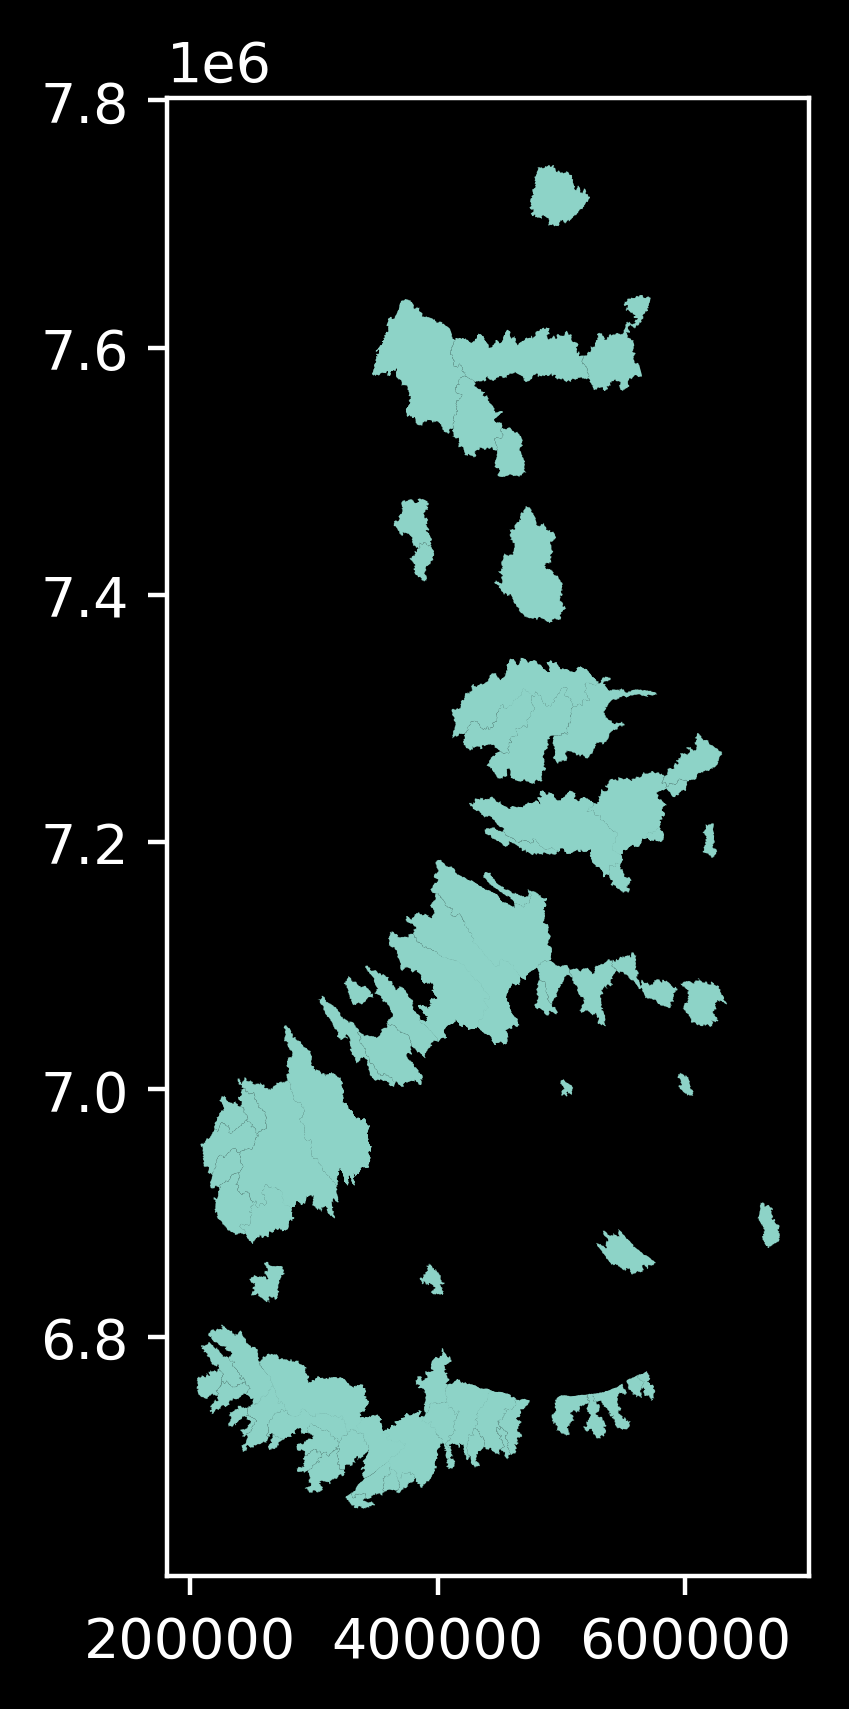

In [4]:
watersheds.plot()